# Data

The same randomly generated data as used in the [Turing Tutorials GMM notebook](https://github.com/TuringLang/TuringTutorials/blob/master/tutorials/01-gaussian-mixture-model/01_gaussian-mixture-model.jmd).

In [1]:
using Distributions
using FillArrays
using StatsPlots

using LinearAlgebra
using Random
import Random: GLOBAL_RNG

using Turing

# Set a random seed.
Random.seed!(3)

# Define Gaussian mixture model.
w = [0.5, 0.5]  # weights for clusters (can be viewed as priors)
μ = [-3.5, 0.5] # means for clusters
mixturemodel = MixtureModel([MvNormal(Fill(μₖ, 2), I) for μₖ in μ], w)

# We draw the data points.
N = 60 # number of data points in each cluster
x = rand(mixturemodel, N); # 2x60 Matrix{Float64} (dimension x datapoints)

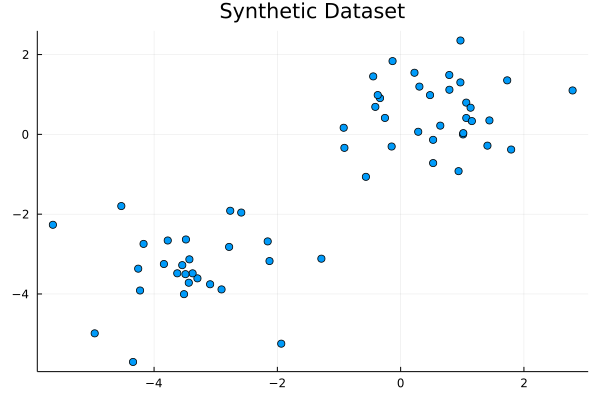

In [2]:
scatter(x[1, :], x[2, :]; legend=false, title="Synthetic Dataset")

# Model & utils

Turing model and utility functions.

In [3]:
"""
Initialize parameters given `D` (dimensionality of the data) and `K` (number of clusters).
"""
init_param(rng=GLOBAL_RNG; D=2, K=2) = randn(rng, (D, K))

@model function em_gmm(x, param; K=2)
    D, N = size(x)
    # Parameters: MVNs' means
    μ = param
    # Priors/weights of μs
    w = fill(1/K, K)
    # Distribution assignments
    r = Categorical(w)
    # Clusters (posterior MVNs)
    𝓝 = [MvNormal(μₖ, I) for μₖ in eachcol(μ)]

    # Latents
    k = tzeros(Int, N)
    
    for i in 1:N
        k[i] ~ r
        x[:, i] ~ 𝓝[k[i]]
    end
    
    return k
end

"""
Get the latents (`k`) from the chain.
Use only the last `keep_pct` of the chain runs and use every `use_every` value.
"""
function get_latent(chain; keep_pct=.5, use_every=10)
    chain.value.data[floor(Int, keep_pct * end) : use_every : end, 1:60] |> Matrix{Int} |> transpose # [latent_dim, num_samples]
end

"""
Make the optimization objective for `Optim.optimize` based on the result of `get_latent`.
"""
function make_obj(latent)
    param -> -mean([logjoint(em_gmm(x, param), (; k=k)) for k in eachcol(latent)])
end

make_obj

# E-step sanity check

Make sure that the E-step works correctly.

In [4]:
# Sample based on ground truth μ

chain = sample(em_gmm(x, repeat(μ, 1, 2)'), PG(100), 100);

Sampling   0%|                                          |  ETA: N/A


Sampling   1%|▍                                         |  ETA: 0:18:21


Sampling   2%|▉                                         |  ETA: 0:10:00


Sampling   3%|█▎                                        |  ETA: 0:07:05


Sampling   4%|█▋                                        |  ETA: 0:05:36


Sampling   5%|██▏                                       |  ETA: 0:04:42


Sampling   6%|██▌                                       |  ETA: 0:04:05


Sampling   7%|███                                       |  ETA: 0:03:39


Sampling   8%|███▍                                      |  ETA: 0:03:20


Sampling   9%|███▊                                      |  ETA: 0:03:04


Sampling  10%|████▎                                     |  ETA: 0:02:53


Sampling  11%|████▋                                     |  ETA: 0:02:42


Sampling  12%|█████                                     |  ETA: 0:02:33


Sampling  13%|█████▌                                    |  ETA: 0:02:25


Sampling  14%|█████▉                                    |  ETA: 0:02:18


Sampling  15%|██████▎                                   |  ETA: 0:02:12


Sampling  16%|██████▊                                   |  ETA: 0:02:07


Sampling  17%|███████▏                                  |  ETA: 0:02:02


Sampling  18%|███████▌                                  |  ETA: 0:01:58


Sampling  19%|████████                                  |  ETA: 0:01:54


Sampling  20%|████████▍                                 |  ETA: 0:01:50


Sampling  21%|████████▉                                 |  ETA: 0:01:47


Sampling  22%|█████████▎                                |  ETA: 0:01:43


Sampling  23%|█████████▋                                |  ETA: 0:01:40


Sampling  24%|██████████▏                               |  ETA: 0:01:37


Sampling  25%|██████████▌                               |  ETA: 0:01:35


Sampling  26%|██████████▉                               |  ETA: 0:01:32


Sampling  27%|███████████▍                              |  ETA: 0:01:30


Sampling  28%|███████████▊                              |  ETA: 0:01:28


Sampling  29%|████████████▏                             |  ETA: 0:01:25


Sampling  30%|████████████▋                             |  ETA: 0:01:23


Sampling  31%|█████████████                             |  ETA: 0:01:21


Sampling  32%|█████████████▌                            |  ETA: 0:01:19


Sampling  33%|█████████████▉                            |  ETA: 0:01:18


Sampling  34%|██████████████▎                           |  ETA: 0:01:16


Sampling  35%|██████████████▊                           |  ETA: 0:01:14


Sampling  36%|███████████████▏                          |  ETA: 0:01:12


Sampling  37%|███████████████▌                          |  ETA: 0:01:10


Sampling  38%|████████████████                          |  ETA: 0:01:09


Sampling  39%|████████████████▍                         |  ETA: 0:01:07


Sampling  40%|████████████████▊                         |  ETA: 0:01:06


Sampling  41%|█████████████████▎                        |  ETA: 0:01:04


Sampling  42%|█████████████████▋                        |  ETA: 0:01:02


Sampling  43%|██████████████████                        |  ETA: 0:01:01


Sampling  44%|██████████████████▌                       |  ETA: 0:01:00


Sampling  45%|██████████████████▉                       |  ETA: 0:00:58


Sampling  46%|███████████████████▍                      |  ETA: 0:00:57


Sampling  47%|███████████████████▊                      |  ETA: 0:00:55


Sampling  48%|████████████████████▏                     |  ETA: 0:00:54


Sampling  49%|████████████████████▋                     |  ETA: 0:00:53


Sampling  50%|█████████████████████                     |  ETA: 0:00:52


Sampling  51%|█████████████████████▍                    |  ETA: 0:00:50


Sampling  52%|█████████████████████▉                    |  ETA: 0:00:49


Sampling  53%|██████████████████████▎                   |  ETA: 0:00:48


Sampling  54%|██████████████████████▋                   |  ETA: 0:00:47


Sampling  55%|███████████████████████▏                  |  ETA: 0:00:46


Sampling  56%|███████████████████████▌                  |  ETA: 0:00:45


Sampling  57%|████████████████████████                  |  ETA: 0:00:44


Sampling  58%|████████████████████████▍                 |  ETA: 0:00:43


Sampling  59%|████████████████████████▊                 |  ETA: 0:00:41


Sampling  60%|█████████████████████████▎                |  ETA: 0:00:40


Sampling  61%|█████████████████████████▋                |  ETA: 0:00:39


Sampling  62%|██████████████████████████                |  ETA: 0:00:38


Sampling  63%|██████████████████████████▌               |  ETA: 0:00:37


Sampling  64%|██████████████████████████▉               |  ETA: 0:00:36


Sampling  65%|███████████████████████████▎              |  ETA: 0:00:35


Sampling  66%|███████████████████████████▊              |  ETA: 0:00:34


Sampling  67%|████████████████████████████▏             |  ETA: 0:00:33


Sampling  68%|████████████████████████████▌             |  ETA: 0:00:32


Sampling  69%|█████████████████████████████             |  ETA: 0:00:31


Sampling  70%|█████████████████████████████▍            |  ETA: 0:00:30


Sampling  71%|█████████████████████████████▉            |  ETA: 0:00:29


Sampling  72%|██████████████████████████████▎           |  ETA: 0:00:28


Sampling  73%|██████████████████████████████▋           |  ETA: 0:00:27


Sampling  74%|███████████████████████████████▏          |  ETA: 0:00:26


Sampling  75%|███████████████████████████████▌          |  ETA: 0:00:25


Sampling  76%|███████████████████████████████▉          |  ETA: 0:00:24


Sampling  77%|████████████████████████████████▍         |  ETA: 0:00:23


Sampling  78%|████████████████████████████████▊         |  ETA: 0:00:22


Sampling  79%|█████████████████████████████████▏        |  ETA: 0:00:21


Sampling  80%|█████████████████████████████████▋        |  ETA: 0:00:20


Sampling  81%|██████████████████████████████████        |  ETA: 0:00:19


Sampling  82%|██████████████████████████████████▌       |  ETA: 0:00:18


Sampling  83%|██████████████████████████████████▉       |  ETA: 0:00:17


Sampling  84%|███████████████████████████████████▎      |  ETA: 0:00:16


Sampling  85%|███████████████████████████████████▊      |  ETA: 0:00:15


Sampling  86%|████████████████████████████████████▏     |  ETA: 0:00:14


Sampling  87%|████████████████████████████████████▌     |  ETA: 0:00:13


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:12


Sampling  89%|█████████████████████████████████████▍    |  ETA: 0:00:11


Sampling  90%|█████████████████████████████████████▊    |  ETA: 0:00:10


Sampling  91%|██████████████████████████████████████▎   |  ETA: 0:00:09


Sampling  92%|██████████████████████████████████████▋   |  ETA: 0:00:08


Sampling  93%|███████████████████████████████████████   |  ETA: 0:00:07


Sampling  94%|███████████████████████████████████████▌  |  ETA: 0:00:06


Sampling  95%|███████████████████████████████████████▉  |  ETA: 0:00:05


Sampling  96%|████████████████████████████████████████▍ |  ETA: 0:00:04


Sampling  97%|████████████████████████████████████████▊ |  ETA: 0:00:03


Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:02


Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:01


Sampling 100%|██████████████████████████████████████████| Time: 0:01:36


Sampling 100%|██████████████████████████████████████████| Time: 0:01:37


In [5]:
# Compare the clusters (roughly, imperfect heuristic)

clusters = map(x_ -> x_[1] < -1 ? 1 : 2, x[1, :]);
sum(clusters .== chain.value[end, 1:60])

60

# Loop

Run the EM version of the GMM algorithm in a loop as containing the E-step and the M-step.

In [9]:
using Optim
using ProgressMeter

Random.seed!(42)

num_particles = 100
num_samples = 100
num_iterations = 4
sampler = PG(num_particles)

param = init_param()
trace = (chn=[], opt=[])

@showprogress for i in 1:num_iterations
    # E-step
    chn = sample(em_gmm(x, param), sampler, num_samples; progress=false)
    push!(trace.chn, chn)

    # M-step
    opt = optimize(make_obj(get_latent(chn)), param)
    push!(trace.opt, opt)
    
    # Get `param` for next iteration 
    param = opt.minimizer
    
    # Report
    @show i
    flush(stdout)
    display(param)
end

i = 1


2×2 Matrix{Float64}:
 0.718382  -2.40469
 0.352202  -2.14434

i = 2


2×2 Matrix{Float64}:
 0.595401  -3.34725
 0.564739  -3.25702

Progress:  50%|████████████████████▌                    |  ETA: 0:02:22

i = 3


2×2 Matrix{Float64}:
 0.568277  -3.4112
 0.541589  -3.32284

Progress:  75%|██████████████████████████████▊          |  ETA: 0:01:16

i = 4


2×2 Matrix{Float64}:
 0.562565  -3.42879
 0.533481  -3.33678

Progress: 100%|█████████████████████████████████████████| Time: 0:05:11


# Evaluation

Evaluate the result

In [10]:
#=
Get the final parameters from optimizer trace.
Round it to the third digit after the comma and sort the columns
to enable comparison with true params.
=#

display("Final param:")
final_param = sort(round.(trace.opt[end].minimizer; digits=3); dims=2)
display(final_param)

#=
Reshape the true parameters and sort them as well.
=#

display("True param:")
true_param = sort(repeat(μ, 1, 2)'; dims=2)
display(true_param)

#=
Compute the difference between the true and predicted parameters.
=#

display("Sorted param element-wise difference:")
diff = abs.(final_param .- true_param)
display(diff)

"Final param:"

2×2 Matrix{Float64}:
 -3.429  0.563
 -3.337  0.533

"True param:"

2×2 Matrix{Float64}:
 -3.5  0.5
 -3.5  0.5

"Sorted param element-wise difference:"

2×2 Matrix{Float64}:
 0.071  0.063
 0.163  0.033

# Plots

See how the log-joint probability changed across the algorithm iterations.

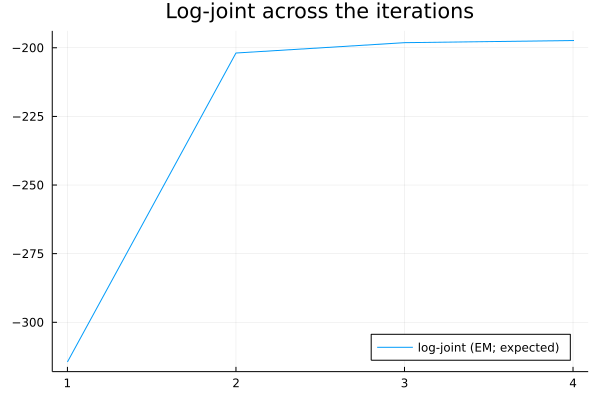

In [11]:
plot(map(opt -> -opt.minimum, trace.opt);
     label="log-joint (EM; expected)",
     legend=:bottomright,
     title="Log-joint across the iterations")

Plot parameters (cluster centers) predicted by EM against the datapoints and true cluster centers

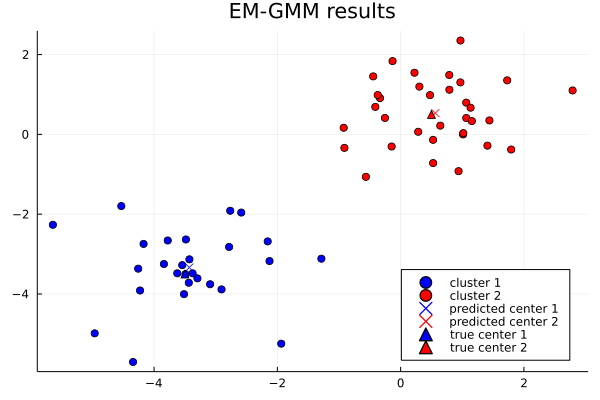

In [14]:
using Distances
using StatsBase

second(x) = x[2]

# Predict clusters for datapoints based on which cluster center is the closest
pred_clusters = second.(argmin(pairwise(Euclidean(), x, final_param;
                                        dims=2);
                               dims=2)
                        )

                        # Get indices of datapoints belonging to both clusters
cluster_1 = [i for (i, c) in enumerate(pred_clusters) if c == 1]
cluster_2 = [i for (i, c) in enumerate(pred_clusters) if c == 2]

# Plot datapoints in color depending on cluster
scatter(x[1, cluster_1], x[2, cluster_1];
        label="cluster 1",
        color="blue",
        legend=:bottomright,
        title="EM-GMM results")
scatter!(x[1, cluster_2], x[2, cluster_2];
         label="cluster 2",
         color="red")

# Plot cluster centers predicted by the algorithm (as crosses)
scatter!([final_param[1, 1]], [final_param[2, 1]];
         label="predicted center 1",
         marker=:x,
         color="blue")
scatter!([final_param[1, 2]], [final_param[2, 2]];
         label="predicted center 2",
         marker=:x,
         color="red")

# Plot true cluster centers (as triangles)
scatter!([true_param[1, 1]], [true_param[2, 1]];
         label="true center 1",
         marker=:^,
         color="blue")
scatter!([true_param[1, 2]], [true_param[2, 2]];
         label="true center 2",
         marker=:^,
         color="red")